In [ ]:
!pip install -r requirements.txt

In [1]:
# This file contains all the main external libs we'll use
from fastai.vision.all import *
import os
import datetime
import shutil
import numpy as np
import os
from azure.storage.blob import BlobServiceClient, BlobClient
from azure.storage.blob import ContentSettings, ContainerClient
from PIL import Image
from fastai.callback.fp16 import *

In [ ]:
#for training on gpu install run this code
#!pip install torch===1.7.1+cu110 torchvision===0.8.2+cu110 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html --user

In [2]:
import torch 
from numba import cuda

In [3]:
device = torch.device("cuda")
torch.cuda.get_device_name(0)
torch.cuda.set_device(0)

In [ ]:
searchterms = ["groeistadia","week"]
# download_blobs.py
# Python program to bulk download blob files from azure storage
# Uses latest python SDK() for Azure blob storage
# Requires python 3.6 or above

if os.path.exists("Plant") and os.path.isdir("Plant"):
  shutil.rmtree("Plant")
os.mkdir("Plant") 

# IMPORTANT: Replace connection string with your storage account connection string
# Usually starts with DefaultEndpointsProtocol=https;...
MY_CONNECTION_STRING = "DefaultEndpointsProtocol=https;AccountName=storagemainfotosplanten;AccountKey=YHIqjHCcXi8IO3DabS+N1lRzrBoltBaDDofu9vJmMo2tMQghoHMQ8fKT/GXVD0Q569EW8pfuJVqv7CjVkPreVA==;EndpointSuffix=core.windows.net"
blob_service_client = BlobServiceClient.from_connection_string(MY_CONNECTION_STRING)

all_containers = blob_service_client.list_containers(include_metadata=True)
for container in all_containers:
  for searchterm in searchterms:
    if searchterm in container['name']:
        print(container['name'])
        # Replace with blob container
        MY_BLOB_CONTAINER = container['name']
        path = "Plant/" + container['name']
        if os.path.exists(path) and os.path.isdir(path):
          shutil.rmtree(path)
        os.mkdir(path)
        # Replace with the local folder where you want files to be downloaded
        LOCAL_BLOB_PATH = path
        
        class AzureBlobFileDownloader:
          def __init__(self):
            print("Intializing AzureBlobFileDownloader")
        
            # Initialize the connection to Azure storage account
            self.blob_service_client =  BlobServiceClient.from_connection_string(MY_CONNECTION_STRING)
            self.my_container = self.blob_service_client.get_container_client(MY_BLOB_CONTAINER)
        
        
          def save_blob(self,file_name,file_content):
            # Get full path to the file
            download_file_path = os.path.join(LOCAL_BLOB_PATH, file_name)
        
            # for nested blobs, create local path as well!
            os.makedirs(os.path.dirname(download_file_path), exist_ok=True)
        
            with open(download_file_path, "wb") as file:
              file.write(file_content)
        
          def download_all_blobs_in_container(self):
            my_blobs = self.my_container.list_blobs()
            for blob in my_blobs:
              print(blob.name)
              bytes = self.my_container.get_blob_client(blob).download_blob().readall()
              self.save_blob(blob.name, bytes)
        
        # Initialize class and upload files
        azure_blob_file_downloader = AzureBlobFileDownloader()
        azure_blob_file_downloader.download_all_blobs_in_container()

In [9]:

filenames = get_image_files(path)
filenames

(#6056) [Path('Plant/fles-week-1/IMG_20220126_094804_001.jpg'),Path('Plant/fles-week-1/IMG_20220126_094804_002.jpg'),Path('Plant/fles-week-1/IMG_20220126_094804_003.jpg'),Path('Plant/fles-week-1/IMG_20220126_094804_004.jpg'),Path('Plant/fles-week-1/IMG_20220126_094804_005.jpg'),Path('Plant/fles-week-1/IMG_20220126_094804_006.jpg'),Path('Plant/fles-week-1/IMG_20220126_094804_007.jpg'),Path('Plant/fles-week-1/IMG_20220126_094804_008.jpg'),Path('Plant/fles-week-1/IMG_20220126_094804_009.jpg'),Path('Plant/fles-week-1/IMG_20220126_094804_010.jpg')...]

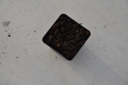

In [4]:
path = 'Plant/'
im = Image.open(path + 'mais-week-1/Pw1 (1).JPG')
im.to_thumb(128,128)

In [ ]:
failed = verify_images(filenames)
failed

In [5]:
Mais = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


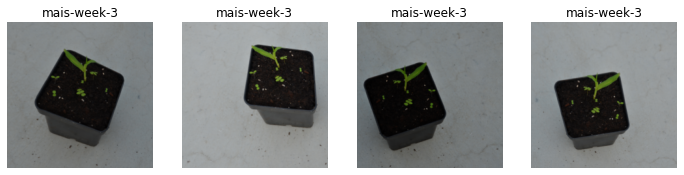

In [6]:
#Mais = Mais.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = Mais.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [7]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    6144 B  |  622282 KB |    2115 MB |    2115 MB |\n|       from large pool |       0 B  |  622271 KB |    2112 MB |    2112 MB |\n|       from small pool |    6144 B  |    1603 KB |       2 MB |       2 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |    6144 B  |  622282 KB |    2115 MB |    2115 MB |\n|       from large pool |       0 B  |  622271 KB |

In [8]:
import torch
torch.cuda.empty_cache()

In [9]:

model_Resnet152 = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
model_Resnet152.fit_one_cycle(3, 3e-3)


In [10]:

torch.cuda.empty_cache()

In [11]:
model_Resnet152.unfreeze()
model_Resnet152.fit_one_cycle(9, lr_max=slice(1e-6,1e-4))

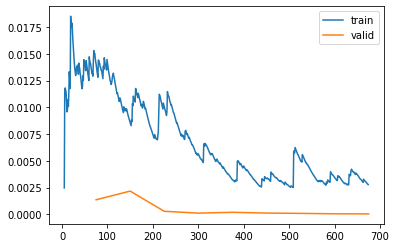

In [12]:
model_Resnet152.recorder.plot_loss()

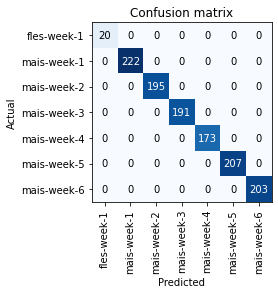

In [13]:
interp = ClassificationInterpretation.from_learner(model_Resnet152)
interp.plot_confusion_matrix()

In [14]:
interp = ClassificationInterpretation.from_learner(model_Resnet152)

def plot_top_losses_fix( interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            #plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), L(self.preds).itemgot(idx), losses,  **kwargs)
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)
        #TODO: figure out if this is needed
        #its None means that a batch knows how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)

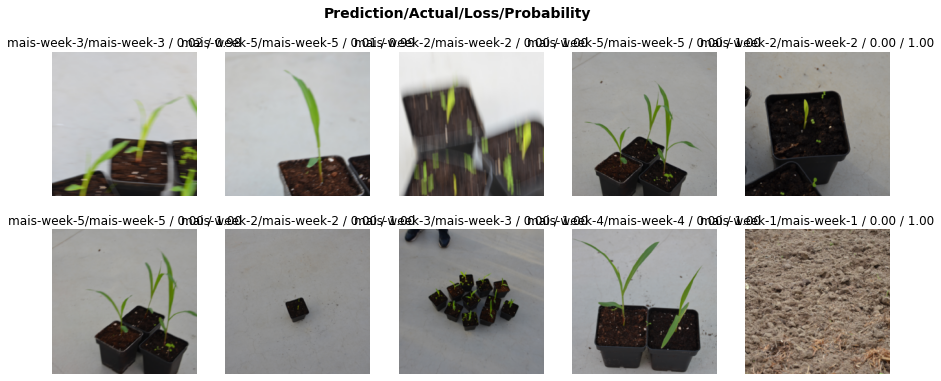

In [15]:
plot_top_losses_fix(interp, 10, nrows=2)

In [16]:
model_Resnet152.save('cuda_model2')
model_Resnet152 = model_Resnet152.to_fp32()
#saving our model, by default in a folder called 'models'.
#creating an serialized pickle object of our model, the export.pkl file

model_Resnet152.export()